In [1]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

import torch.optim as optim


# Data preprocessing utils : 
from utils.acdc_dataset import ACDC_Dataset, One_hot_Transform, load_dataset
from torchvision.transforms import Compose
from torchvision import transforms

from torch.utils.data import DataLoader


# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


# my defined model

from utils.acdc_dataset import *
from utils.training import *
from utils.RqVAE import *



## Preparing Dataset 

In [2]:
L = 128 # image size L=W
BATCH_SIZE = 16

In [3]:
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")



#### Segmentation Dataset

In [4]:
train_dataset = load_dataset(train_set_path)
test_dataset  = load_dataset(test_set_path)


input_transforms = Compose([
    transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
    One_hot_Transform(num_classes=4)
    ])


TrainDataset = ACDC_Dataset(data = train_dataset, transforms= input_transforms) 
TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TrainLoader  = DataLoader(TrainDataset, batch_size = BATCH_SIZE, shuffle = True)
TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = True)



## Prepairing the model

In [5]:
K =  512 # num_embeddings
D =  64 # embedding_dim
in_channels = 4 
num_quantizers = 2
downsampling_factor = 4
shared_codebook = False

In [6]:
# ACDC_VQVAE = VQVAE(in_channels, D, K, downsampling_factor)
ACDC_RQVAE = RQVAE(in_channels= in_channels,
                embedding_dim= D,
                num_embeddings= K,
                num_quantizers= num_quantizers,
                shared_codebook= shared_codebook,
                downsampling_factor= downsampling_factor )


## Training the Model

In [7]:
# detect gpu ?

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)



True
cuda:0


In [11]:
### Learning parameters

model = ACDC_RQVAE.to(device)

lr = 5e-4
epochs = 100
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

model_name = 'saved_models_Residual/vqvae_400_bestmodel.pth'

In [9]:
# visualisation batch, to track th eperformance of the model
vis_batch = next(iter(TestLoader)).to(device)

In [12]:

model.train()
train_loss_values = []
codebook_loss_values = []

#track the evolution of reconstruction
recons_evolution = []

val_loss_values = []
best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss = 0.0
    codebook_loss_epoch = 0.0

    with tqdm(enumerate(TrainLoader), unit="batch", total=len(TrainLoader)) as tepoch:
        for batch_idx, (inputs) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, inputs, indices, commit_loss = model(inputs)
            
            # Loss and backward
            loss = model.loss_function(output, inputs, indices, commit_loss)['loss']  # Use the loss function defined in the model
            loss.backward()
            optimizer.step()
            
            
            # Track running loss
            train_loss += loss.item()
            codebook_loss_epoch += torch.sum(commit_loss).item()


            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = train_loss / len(TrainLoader.dataset)
    codebook_loss_epoch/= len(TrainLoader.dataset)

    train_loss_values.append(epoch_loss)
    codebook_loss_values.append(codebook_loss_epoch)

    # Validation after each epoch
    val_loss = evaluate_model_with_mse(model, TestLoader, device)
    val_loss_values.append(val_loss)

    #track output precision progression every 10 epoch:
    if (epoch%5 == 0 and epoch<50):
        output, _, _, _ = model( vis_batch.float() )
        recons_evolution.append(output)


    #saving model if Loss values decreases
    if val_loss < best_val_loss :
        save_RQ_model(model_name, model, epoch, train_loss_values, val_loss_values, codebook_loss_values)

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(TrainLoader)))

print("Training complete.")

  0%|          | 0/119 [00:00<?, ?batch/s]

100%|██████████| 119/119 [00:06<00:00, 18.13batch/s, loss=0.0287]


Epoch 0: Train Loss: 0.0534


100%|██████████| 119/119 [00:06<00:00, 19.77batch/s, loss=0.0214]


Epoch 1: Train Loss: 0.0220


100%|██████████| 119/119 [00:06<00:00, 18.89batch/s, loss=0.0176]


Epoch 2: Train Loss: 0.0191


100%|██████████| 119/119 [00:06<00:00, 18.68batch/s, loss=0.0163]


Epoch 3: Train Loss: 0.0172


100%|██████████| 119/119 [00:06<00:00, 19.06batch/s, loss=0.0123]


Epoch 4: Train Loss: 0.0155


100%|██████████| 119/119 [00:06<00:00, 18.79batch/s, loss=0.0151]


Epoch 5: Train Loss: 0.0144


100%|██████████| 119/119 [00:06<00:00, 19.38batch/s, loss=0.0129]


Epoch 6: Train Loss: 0.0133


100%|██████████| 119/119 [00:06<00:00, 18.50batch/s, loss=0.00969]


Epoch 7: Train Loss: 0.0123


100%|██████████| 119/119 [00:06<00:00, 18.57batch/s, loss=0.00879]


Epoch 8: Train Loss: 0.0108


100%|██████████| 119/119 [00:06<00:00, 19.22batch/s, loss=0.00813]


Epoch 9: Train Loss: 0.0093


100%|██████████| 119/119 [00:06<00:00, 19.32batch/s, loss=0.00787]


Epoch 10: Train Loss: 0.0081


100%|██████████| 119/119 [00:05<00:00, 19.87batch/s, loss=0.00834]


Epoch 11: Train Loss: 0.0074


100%|██████████| 119/119 [00:06<00:00, 19.09batch/s, loss=0.00581]


Epoch 12: Train Loss: 0.0065


100%|██████████| 119/119 [00:06<00:00, 19.42batch/s, loss=0.00565]


Epoch 13: Train Loss: 0.0060


100%|██████████| 119/119 [00:05<00:00, 20.46batch/s, loss=0.00537]


Epoch 14: Train Loss: 0.0054


100%|██████████| 119/119 [00:05<00:00, 20.26batch/s, loss=0.0047] 


Epoch 15: Train Loss: 0.0054


100%|██████████| 119/119 [00:05<00:00, 19.86batch/s, loss=0.0051] 


Epoch 16: Train Loss: 0.0047


100%|██████████| 119/119 [00:05<00:00, 20.20batch/s, loss=0.005]  


Epoch 17: Train Loss: 0.0045


100%|██████████| 119/119 [00:05<00:00, 20.42batch/s, loss=0.00393]


Epoch 18: Train Loss: 0.0041


100%|██████████| 119/119 [00:05<00:00, 20.83batch/s, loss=0.00354]


Epoch 19: Train Loss: 0.0038


100%|██████████| 119/119 [00:05<00:00, 20.41batch/s, loss=0.00316]


Epoch 20: Train Loss: 0.0035


100%|██████████| 119/119 [00:05<00:00, 21.11batch/s, loss=0.00439]


Epoch 21: Train Loss: 0.0037


100%|██████████| 119/119 [00:05<00:00, 20.85batch/s, loss=0.0019] 


Epoch 22: Train Loss: 0.0031


100%|██████████| 119/119 [00:05<00:00, 21.30batch/s, loss=0.00265]


Epoch 23: Train Loss: 0.0029


100%|██████████| 119/119 [00:05<00:00, 21.24batch/s, loss=0.00224]


Epoch 24: Train Loss: 0.0027


100%|██████████| 119/119 [00:05<00:00, 21.16batch/s, loss=0.00218]


Epoch 25: Train Loss: 0.0025


100%|██████████| 119/119 [00:05<00:00, 20.51batch/s, loss=0.00277]


Epoch 26: Train Loss: 0.0025


100%|██████████| 119/119 [00:05<00:00, 19.91batch/s, loss=0.00175]


Epoch 27: Train Loss: 0.0023


100%|██████████| 119/119 [00:05<00:00, 20.89batch/s, loss=0.00195]


Epoch 28: Train Loss: 0.0021


100%|██████████| 119/119 [00:05<00:00, 20.16batch/s, loss=0.00191]


Epoch 29: Train Loss: 0.0020


100%|██████████| 119/119 [00:05<00:00, 20.29batch/s, loss=0.00199]


Epoch 30: Train Loss: 0.0019


100%|██████████| 119/119 [00:05<00:00, 20.69batch/s, loss=0.00188]


Epoch 31: Train Loss: 0.0019


100%|██████████| 119/119 [00:05<00:00, 21.28batch/s, loss=0.00188]


Epoch 32: Train Loss: 0.0017


100%|██████████| 119/119 [00:06<00:00, 18.75batch/s, loss=0.00217]


Epoch 33: Train Loss: 0.0017


100%|██████████| 119/119 [00:05<00:00, 20.64batch/s, loss=0.0167]


Epoch 34: Train Loss: 0.0689


100%|██████████| 119/119 [00:06<00:00, 19.30batch/s, loss=0.0142]


Epoch 35: Train Loss: 0.0149


100%|██████████| 119/119 [00:06<00:00, 19.40batch/s, loss=0.00992]


Epoch 36: Train Loss: 0.0123


100%|██████████| 119/119 [00:05<00:00, 21.34batch/s, loss=0.00759]


Epoch 37: Train Loss: 0.0102


100%|██████████| 119/119 [00:05<00:00, 20.19batch/s, loss=0.00886]


Epoch 38: Train Loss: 0.0082


100%|██████████| 119/119 [00:05<00:00, 20.55batch/s, loss=0.00619]


Epoch 39: Train Loss: 0.0068


100%|██████████| 119/119 [00:05<00:00, 20.27batch/s, loss=0.00519]


Epoch 40: Train Loss: 0.0057


100%|██████████| 119/119 [00:05<00:00, 20.58batch/s, loss=0.00502]


Epoch 41: Train Loss: 0.0050


100%|██████████| 119/119 [00:05<00:00, 19.92batch/s, loss=0.00353]


Epoch 42: Train Loss: 0.0044


100%|██████████| 119/119 [00:05<00:00, 20.47batch/s, loss=0.0036] 


Epoch 43: Train Loss: 0.0040


100%|██████████| 119/119 [00:05<00:00, 20.61batch/s, loss=0.00311]


Epoch 44: Train Loss: 0.0036


100%|██████████| 119/119 [00:05<00:00, 19.84batch/s, loss=0.00319]


Epoch 45: Train Loss: 0.0033


100%|██████████| 119/119 [00:05<00:00, 21.24batch/s, loss=0.00258]


Epoch 46: Train Loss: 0.0030


100%|██████████| 119/119 [00:05<00:00, 20.77batch/s, loss=0.00291]


Epoch 47: Train Loss: 0.0028


100%|██████████| 119/119 [00:06<00:00, 19.26batch/s, loss=0.00293]


Epoch 48: Train Loss: 0.0026


100%|██████████| 119/119 [00:05<00:00, 21.24batch/s, loss=0.0022] 


Epoch 49: Train Loss: 0.0025


100%|██████████| 119/119 [00:05<00:00, 20.53batch/s, loss=0.00239]


Epoch 50: Train Loss: 0.0023


100%|██████████| 119/119 [00:05<00:00, 20.49batch/s, loss=0.0023] 


Epoch 51: Train Loss: 0.0023


100%|██████████| 119/119 [00:05<00:00, 20.80batch/s, loss=0.00245]


Epoch 52: Train Loss: 0.0021


100%|██████████| 119/119 [00:05<00:00, 21.25batch/s, loss=0.00219]


Epoch 53: Train Loss: 0.0020


100%|██████████| 119/119 [00:05<00:00, 19.92batch/s, loss=0.00204]


Epoch 54: Train Loss: 0.0019


100%|██████████| 119/119 [00:05<00:00, 21.09batch/s, loss=0.00208]


Epoch 55: Train Loss: 0.0018


100%|██████████| 119/119 [00:05<00:00, 20.82batch/s, loss=0.00165]


Epoch 56: Train Loss: 0.0018


100%|██████████| 119/119 [00:05<00:00, 20.24batch/s, loss=0.00138]


Epoch 57: Train Loss: 0.0019


100%|██████████| 119/119 [00:05<00:00, 20.17batch/s, loss=0.00164]


Epoch 58: Train Loss: 0.0016


100%|██████████| 119/119 [00:05<00:00, 20.16batch/s, loss=0.00127]


Epoch 59: Train Loss: 0.0016


100%|██████████| 119/119 [00:05<00:00, 20.44batch/s, loss=0.00127]


Epoch 60: Train Loss: 0.0015


100%|██████████| 119/119 [00:05<00:00, 20.32batch/s, loss=0.00106]


Epoch 61: Train Loss: 0.0014


100%|██████████| 119/119 [00:05<00:00, 21.04batch/s, loss=0.00145]


Epoch 62: Train Loss: 0.0017


100%|██████████| 119/119 [00:05<00:00, 20.67batch/s, loss=0.00152]


Epoch 63: Train Loss: 0.0013


100%|██████████| 119/119 [00:05<00:00, 20.42batch/s, loss=0.00101] 


Epoch 64: Train Loss: 0.0013


100%|██████████| 119/119 [00:05<00:00, 21.00batch/s, loss=0.00179] 


Epoch 65: Train Loss: 0.0012


100%|██████████| 119/119 [00:05<00:00, 20.33batch/s, loss=0.00101] 


Epoch 66: Train Loss: 0.0012


100%|██████████| 119/119 [00:05<00:00, 20.41batch/s, loss=0.00152] 


Epoch 67: Train Loss: 0.0011


100%|██████████| 119/119 [00:05<00:00, 20.59batch/s, loss=0.00546]


Epoch 68: Train Loss: 0.0018


100%|██████████| 119/119 [00:06<00:00, 19.56batch/s, loss=0.00109] 


Epoch 69: Train Loss: 0.0014


100%|██████████| 119/119 [00:05<00:00, 21.03batch/s, loss=0.0011]  


Epoch 70: Train Loss: 0.0010


100%|██████████| 119/119 [00:05<00:00, 20.64batch/s, loss=0.00085] 


Epoch 71: Train Loss: 0.0010


100%|██████████| 119/119 [00:06<00:00, 19.58batch/s, loss=0.000795]


Epoch 72: Train Loss: 0.0009


100%|██████████| 119/119 [00:05<00:00, 20.94batch/s, loss=0.00114] 


Epoch 73: Train Loss: 0.0016


100%|██████████| 119/119 [00:06<00:00, 19.82batch/s, loss=0.000986]


Epoch 74: Train Loss: 0.0009


100%|██████████| 119/119 [00:05<00:00, 20.91batch/s, loss=0.000956]


Epoch 75: Train Loss: 0.0008


100%|██████████| 119/119 [00:05<00:00, 20.72batch/s, loss=0.000988]


Epoch 76: Train Loss: 0.0008


100%|██████████| 119/119 [00:05<00:00, 20.65batch/s, loss=0.00101] 


Epoch 77: Train Loss: 0.0008


100%|██████████| 119/119 [00:05<00:00, 20.73batch/s, loss=0.000727]


Epoch 78: Train Loss: 0.0008


100%|██████████| 119/119 [00:05<00:00, 20.81batch/s, loss=0.000542]


Epoch 79: Train Loss: 0.0008


100%|██████████| 119/119 [00:05<00:00, 20.78batch/s, loss=0.000874]


Epoch 80: Train Loss: 0.0008


100%|██████████| 119/119 [00:05<00:00, 21.15batch/s, loss=0.000907]


Epoch 81: Train Loss: 0.0007


100%|██████████| 119/119 [00:05<00:00, 20.41batch/s, loss=0.000812]


Epoch 82: Train Loss: 0.0008


100%|██████████| 119/119 [00:05<00:00, 20.54batch/s, loss=0.000726]


Epoch 83: Train Loss: 0.0008


100%|██████████| 119/119 [00:05<00:00, 20.98batch/s, loss=0.0252] 


Epoch 84: Train Loss: 0.0261


100%|██████████| 119/119 [00:05<00:00, 20.46batch/s, loss=0.00874]


Epoch 85: Train Loss: 0.0142


100%|██████████| 119/119 [00:05<00:00, 20.57batch/s, loss=0.0061] 


Epoch 86: Train Loss: 0.0078


100%|██████████| 119/119 [00:05<00:00, 21.12batch/s, loss=0.0042] 


Epoch 87: Train Loss: 0.0052


100%|██████████| 119/119 [00:05<00:00, 20.69batch/s, loss=0.00382]


Epoch 88: Train Loss: 0.0036


100%|██████████| 119/119 [00:05<00:00, 20.69batch/s, loss=0.00226]


Epoch 89: Train Loss: 0.0028


100%|██████████| 119/119 [00:05<00:00, 19.93batch/s, loss=0.00204]


Epoch 90: Train Loss: 0.0023


100%|██████████| 119/119 [00:05<00:00, 19.89batch/s, loss=0.00165]


Epoch 91: Train Loss: 0.0020


100%|██████████| 119/119 [00:05<00:00, 20.52batch/s, loss=0.00182]


Epoch 92: Train Loss: 0.0018


100%|██████████| 119/119 [00:06<00:00, 19.74batch/s, loss=0.00162]


Epoch 93: Train Loss: 0.0016


100%|██████████| 119/119 [00:05<00:00, 19.96batch/s, loss=0.00157]


Epoch 94: Train Loss: 0.0015


100%|██████████| 119/119 [00:05<00:00, 20.28batch/s, loss=0.00154]


Epoch 95: Train Loss: 0.0014


100%|██████████| 119/119 [00:05<00:00, 21.52batch/s, loss=0.00126] 


Epoch 96: Train Loss: 0.0013


100%|██████████| 119/119 [00:05<00:00, 20.17batch/s, loss=0.00147] 


Epoch 97: Train Loss: 0.0012


100%|██████████| 119/119 [00:05<00:00, 20.18batch/s, loss=0.00103] 


Epoch 98: Train Loss: 0.0011


100%|██████████| 119/119 [00:05<00:00, 20.64batch/s, loss=0.000817]


Epoch 99: Train Loss: 0.0011
Training complete.


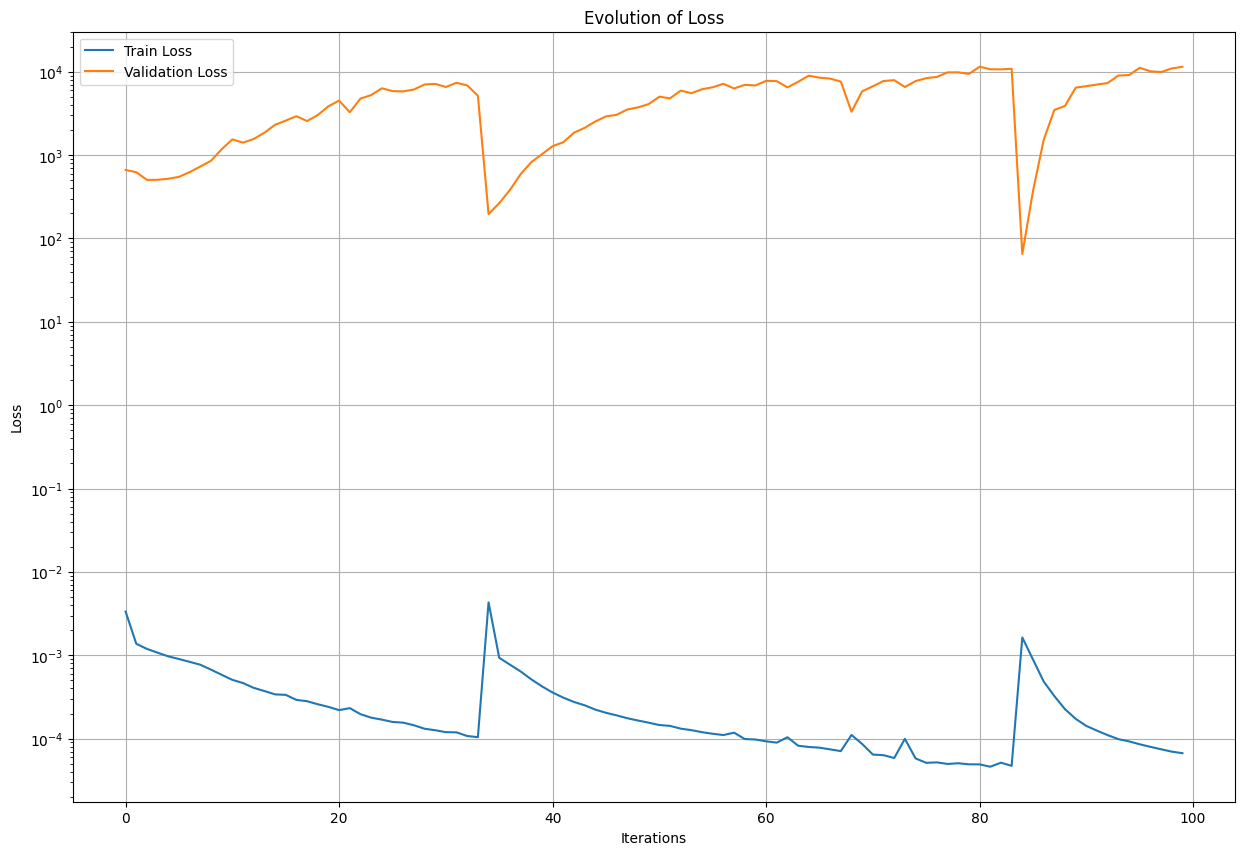

In [13]:
# Plot the training and validation losses
plot_train_val_loss(train_loss_values, val_loss_values)

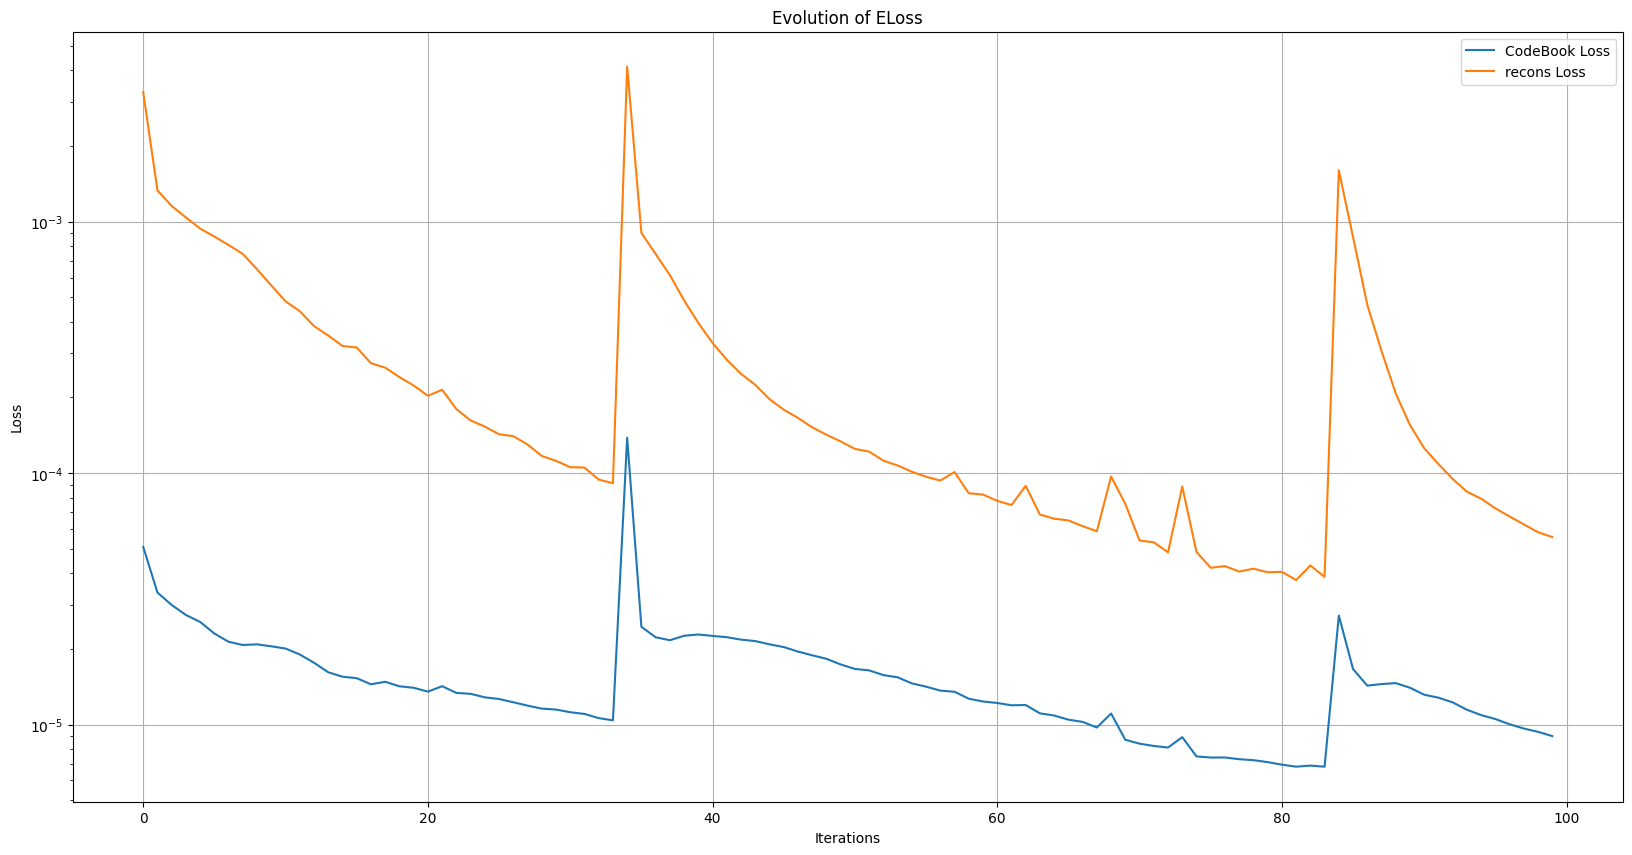

In [14]:

plot_rc_loss(train_loss_values, codebook_loss_values, beta=0.25)


# Test ...

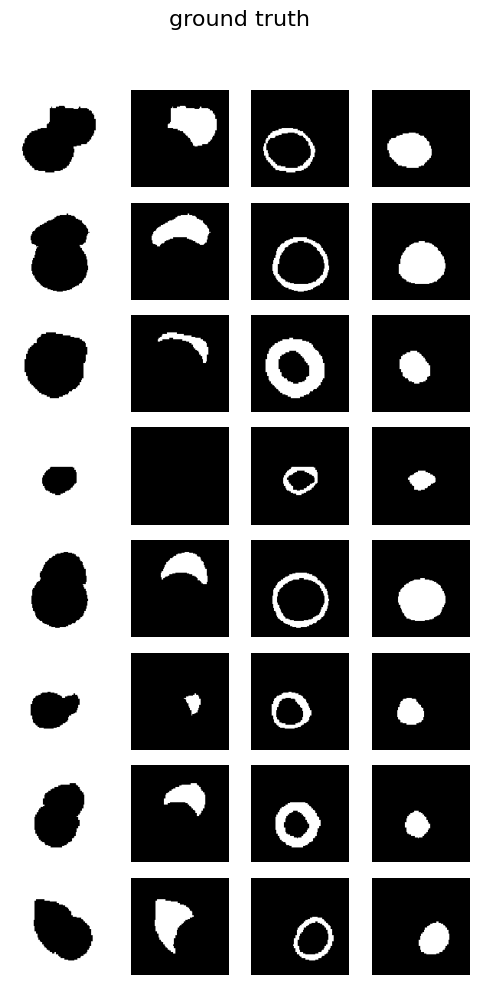

In [15]:
visualize_batch(vis_batch.detach().cpu(), title = "ground truth")

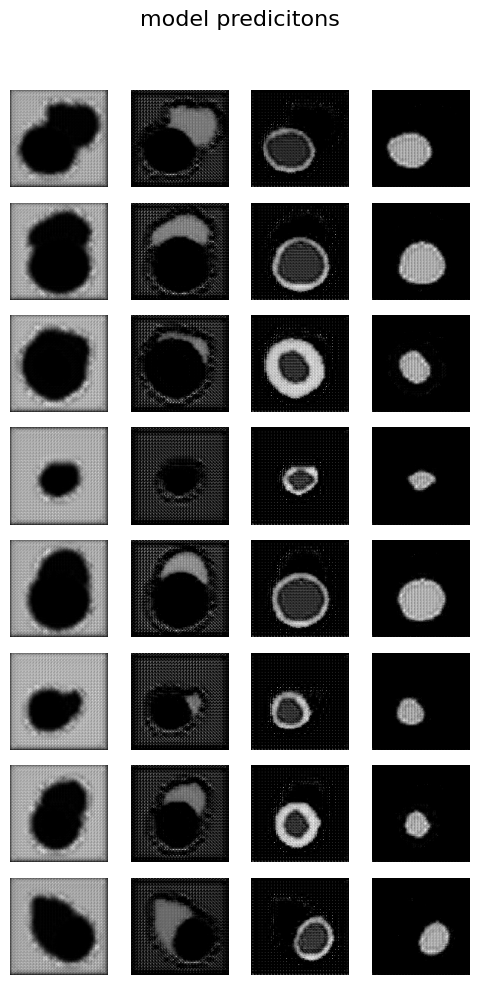

In [16]:
batch_hat = reconstruct_logits(vis_batch, model)

visualize_batch_logits( batch_hat.detach().cpu(), title = "model predicitons")

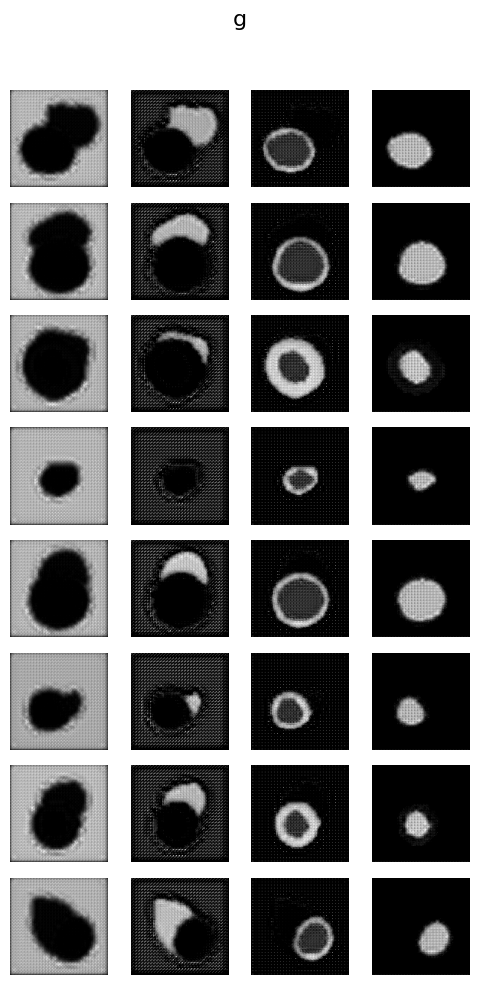

In [18]:
visualize_batch_logits(recons_evolution[-1].detach().cpu(), title = "g")